<a href="https://colab.research.google.com/github/sudeepmenon17/PytorchforNN/blob/main/WT_for_VIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

!pip install google-auth
from google.colab import auth
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#!ls /content/drive/MyDrive/

In [8]:
import numpy as np
from scipy.interpolate import griddata
from scipy.io import loadmat, savemat

# Load the .mat files
vor_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/VORTALL.mat')
time_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/Time.mat')
points_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/points.mat')
cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
# Extract necessary variables
VORTALL = vor_data['VORTALL']  # Vorticity data
Time = time_data['Time'].flatten()  # Time vector (flatten to 1D)
points = points_data['points']  # Points array
CC = cccool_data['CC']  # Colormap

In [9]:
# # Input parameters
# t0 = 400
# A = 0.5  # Amplitude
# omega = 0.2513  # Frequency (RV=5)
# y0 = A * np.sin(t0 * omega)

# # Initial parameters
# It0 = 1
# Dt = 1
# newTime = Time[It0 - 1::Dt]
# px = points[:, 0]
# py = points[:, 1]

# # Transform to ground reference
# py1 = np.zeros((len(py), len(newTime)))
# for i, t in enumerate(newTime):
#     py1[:, i] = py + A * np.sin(t * omega) - y0

# # Grid setup
# nx, ny = 326, 201
# nxi, nyi = nx * 1, ny * 1

# x1 = np.linspace(0.6, 8, nxi)
# y1 = np.linspace(-2.9, 2.9, nyi)
# pxq, pyq = np.meshgrid(x1, y1)

# Nt = nxi * nyi
# pxnew = pxq.flatten()
# pynew = pyq.flatten()

# # Interpolation
# X = VORTALL[2::3, It0 - 1::Dt]
# Xnew = np.zeros((Nt, len(newTime)))
# for i in range(len(newTime)):
#     py2 = py1[:, i].reshape(ny, nx)
#     V = X[:, i].reshape(ny, nx)
#     method = 'cubic'  # Interpolation method
#     Vq = griddata((px, py), V.flatten(), (pxq, pyq), method=method)
#     Xnew[:, i] = Vq.flatten()

# # Save interpolated data
# savemat('/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat', {'Xnew': Xnew, 'pxnew': pxnew, 'pynew': pynew, 'nxi': nxi, 'nyi': nyi, 'Time': newTime})

In [10]:
!pip install PyWavelets
import pywt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# **POD **

<ipython-input-11-000aad2f7346>:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nxi = int(data['nxi'])  # Number of x grid points
<ipython-input-11-000aad2f7346>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nyi = int(data['nyi'])  # Number of y grid points


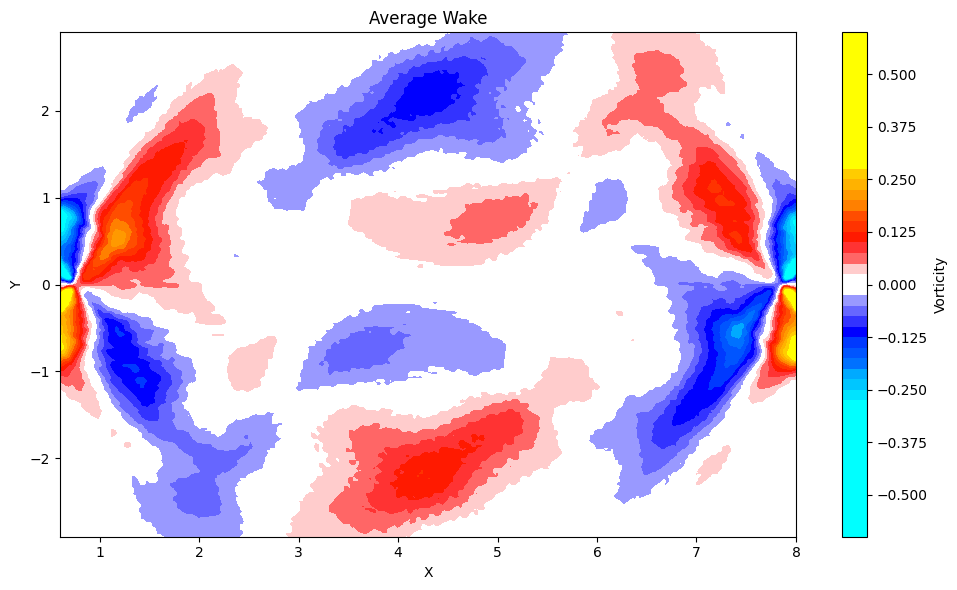

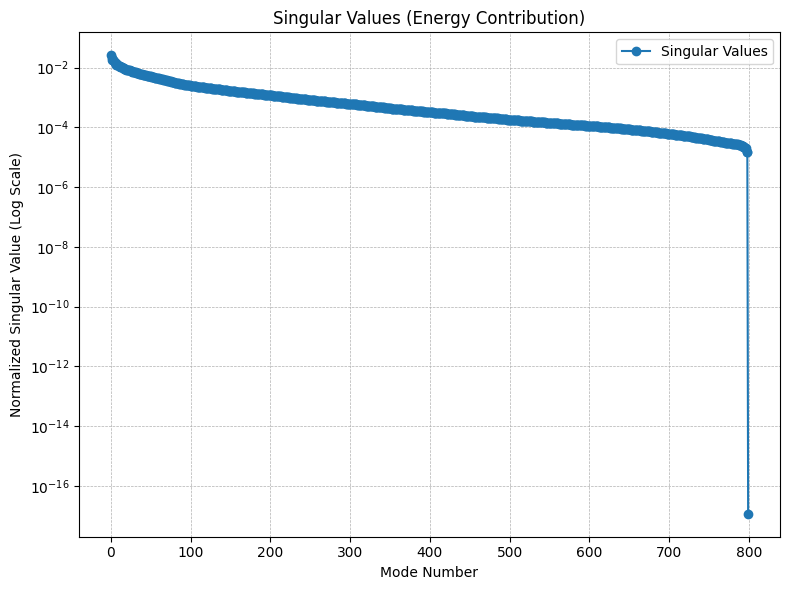

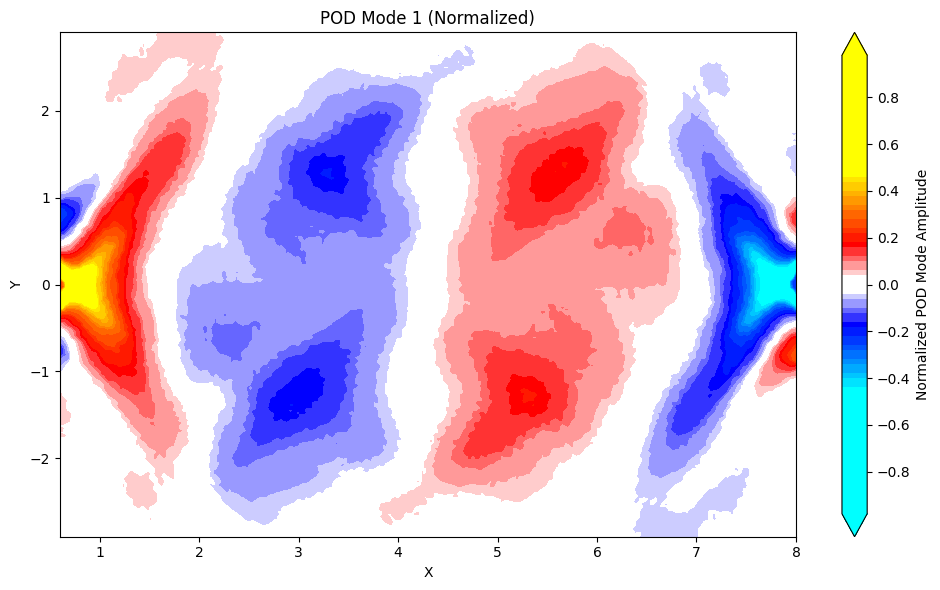

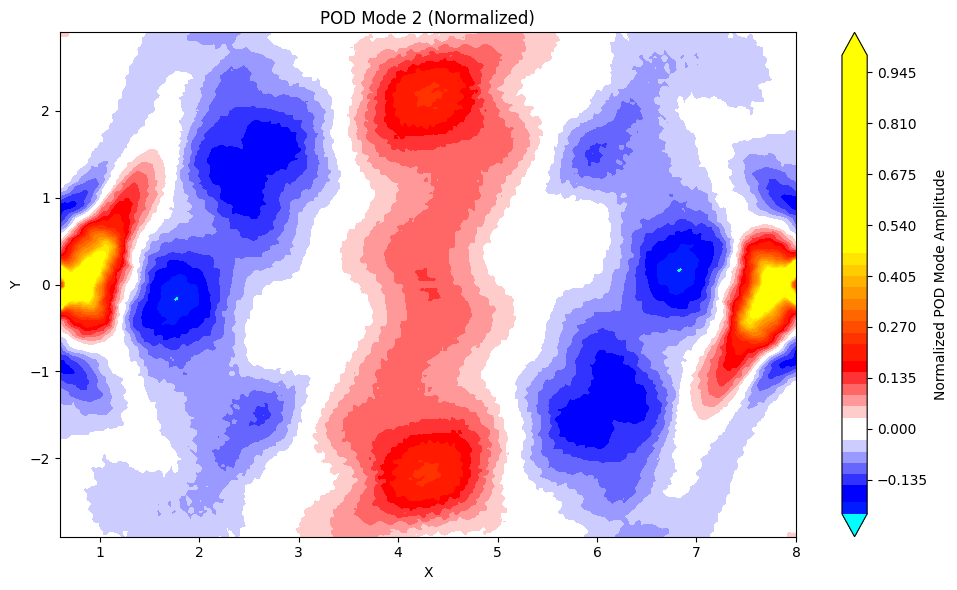

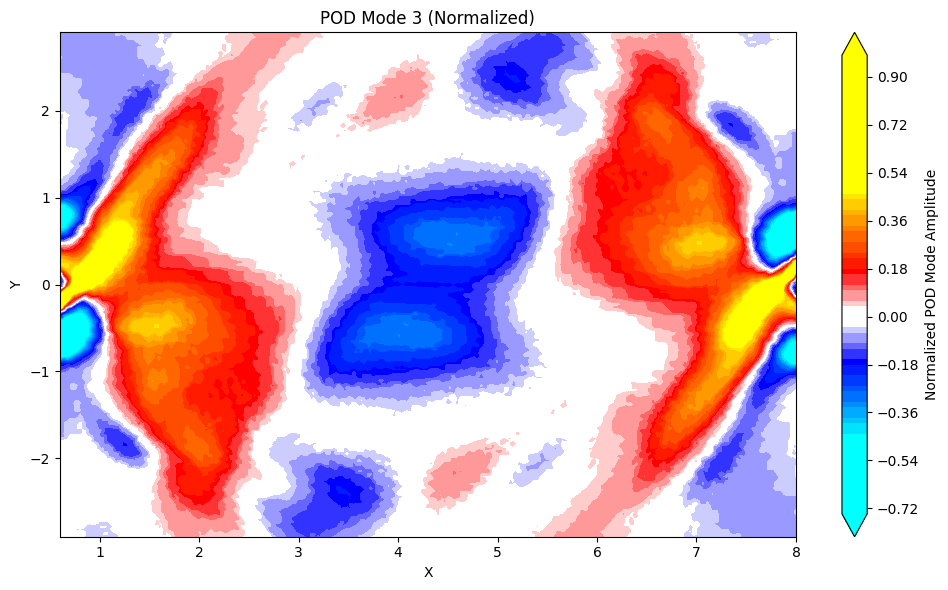

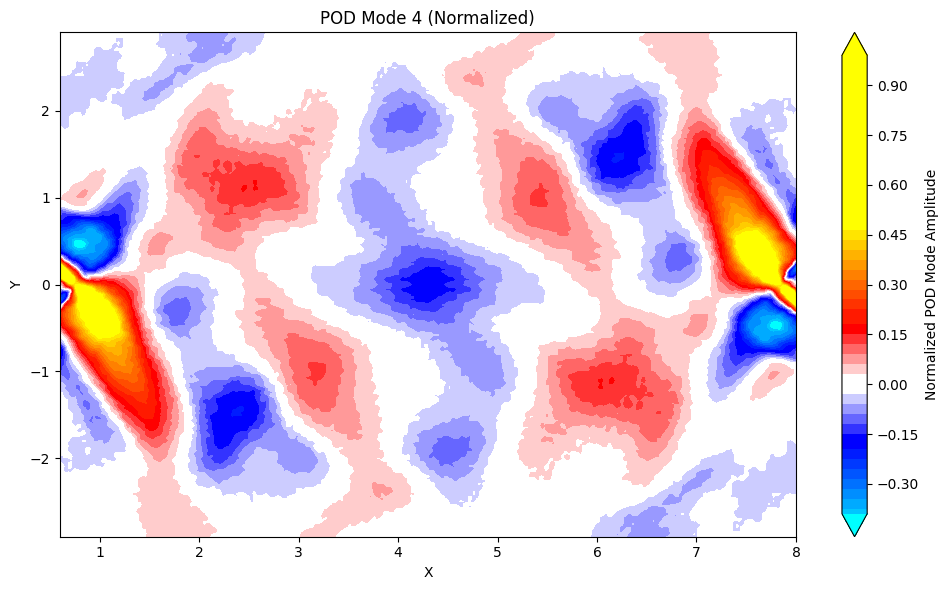

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.linalg import svd
from matplotlib.colors import ListedColormap

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data
nxi = int(data['nxi'])  # Number of x grid points
nyi = int(data['nyi'])  # Number of y grid points
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates

# Load CCcool colormap
cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
CC = cccool_data['CC']
custom_cmap = ListedColormap(CC)

# Step 1: Augment the matrix with mirror images to enforce symmetry/antisymmetry
Y = np.concatenate((Xnew, -np.flipud(Xnew)), axis=1)

# Step 2: Compute the mean and subtract it
VORTavg = np.mean(Y, axis=1)
Y_centered = Y - VORTavg[:, None]

# Plot the average wake
plt.figure(figsize=(10, 6))
plt.contourf(pxnew.reshape(nyi, nxi),
             pynew.reshape(nyi, nxi),
             VORTavg.reshape(nyi, nxi),
             levels=50,
             cmap=custom_cmap)
plt.colorbar(label='Vorticity')
plt.title('Average Wake')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# Step 3: Compute POD (using SVD)
U, S, Vh = svd(Y_centered, full_matrices=False)

# Step 4: Plot singular values
singular_values = S / np.sum(S)
plt.figure(figsize=(8, 6))
plt.semilogy(singular_values, 'o-', label='Singular Values')
plt.title('Singular Values (Energy Contribution)')
plt.xlabel('Mode Number')
plt.ylabel('Normalized Singular Value (Log Scale)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Step 5: Plot the first few POD modes with normalization and improved clarity
num_modes_to_plot = 4  # Number of modes to visualize
for mode in range(num_modes_to_plot):
    POD_mode = U[:, mode].reshape(nyi, nxi)

    # Normalize the mode
    max_abs = np.max(np.abs(POD_mode))
    POD_mode_normalized = POD_mode / max_abs

    # Plot the normalized mode
    plt.figure(figsize=(10, 6))
    plt.contourf(pxnew.reshape(nyi, nxi),
                 pynew.reshape(nyi, nxi),
                 POD_mode_normalized,
                 levels=100,  # Increase contour levels for smoother transitions
                 cmap=custom_cmap,
                 vmin=-1, vmax=1,  # Symmetric colormap range
                 extend='both')
    plt.colorbar(label='Normalized POD Mode Amplitude')
    plt.title(f'POD Mode {mode + 1} (Normalized)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.show()


# **Wavelet Transform**

<ipython-input-12-cd2a24374856>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nxi = int(data['nxi'])  # Number of x grid points
<ipython-input-12-cd2a24374856>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nyi = int(data['nyi'])  # Number of y grid points


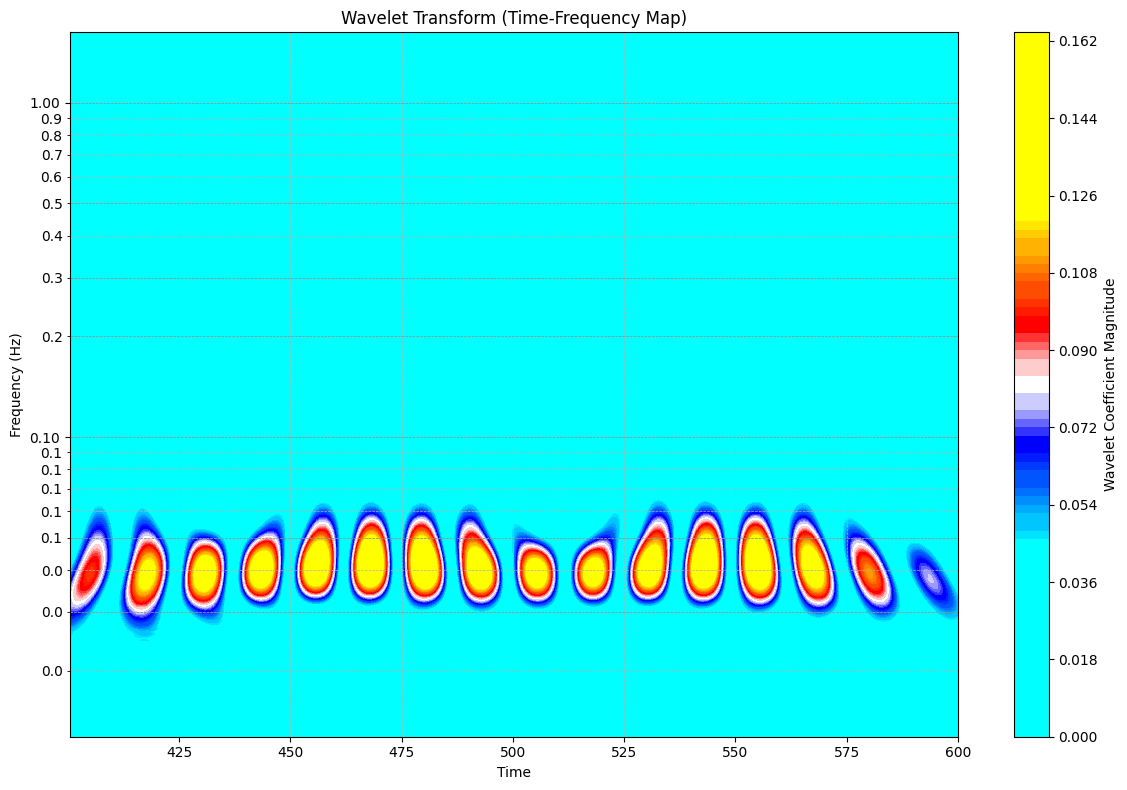

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data
Time = data['Time'].flatten()  # Time array
nxi = int(data['nxi'])  # Number of x grid points
nyi = int(data['nyi'])  # Number of y grid points
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates

# Load CCcool colormap
cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
CC = cccool_data['CC']
custom_cmap = ListedColormap(CC)

# Step 1: Perform wavelet transform for the spatially averaged signal
sampling_period = Time[1] - Time[0]  # Assuming uniform time steps
signal = Xnew.mean(axis=0)  # Spatially averaged signal

# Define scales for wavelet transform
scales = np.linspace(1, 128, 128)  # Adjust scale range as needed
wavelet = 'morl'  # Morlet wavelet
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period)

# Step 2: Plot wavelet transform (time-frequency map)
plt.figure(figsize=(12, 8))
plt.contourf(Time, frequencies, np.abs(coefficients), levels=100, cmap=custom_cmap)
plt.colorbar(label='Wavelet Coefficient Magnitude')

# Explicitly set y-ticks for log scale
yticks = [0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
plt.yticks(
    ticks=yticks,
    labels=[f"{freq:.2f}" for freq in yticks],
    fontsize=10
)

# Add gridlines for all y-ticks
for freq in yticks:
    plt.axhline(y=freq, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.title('Wavelet Transform (Time-Frequency Map)')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.yscale('log')  # Logarithmic scale for better visualization
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())


plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


<ipython-input-13-57915c69552a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nxi = int(data['nxi'])  # Number of x grid points
<ipython-input-13-57915c69552a>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  nyi = int(data['nyi'])  # Number of y grid points


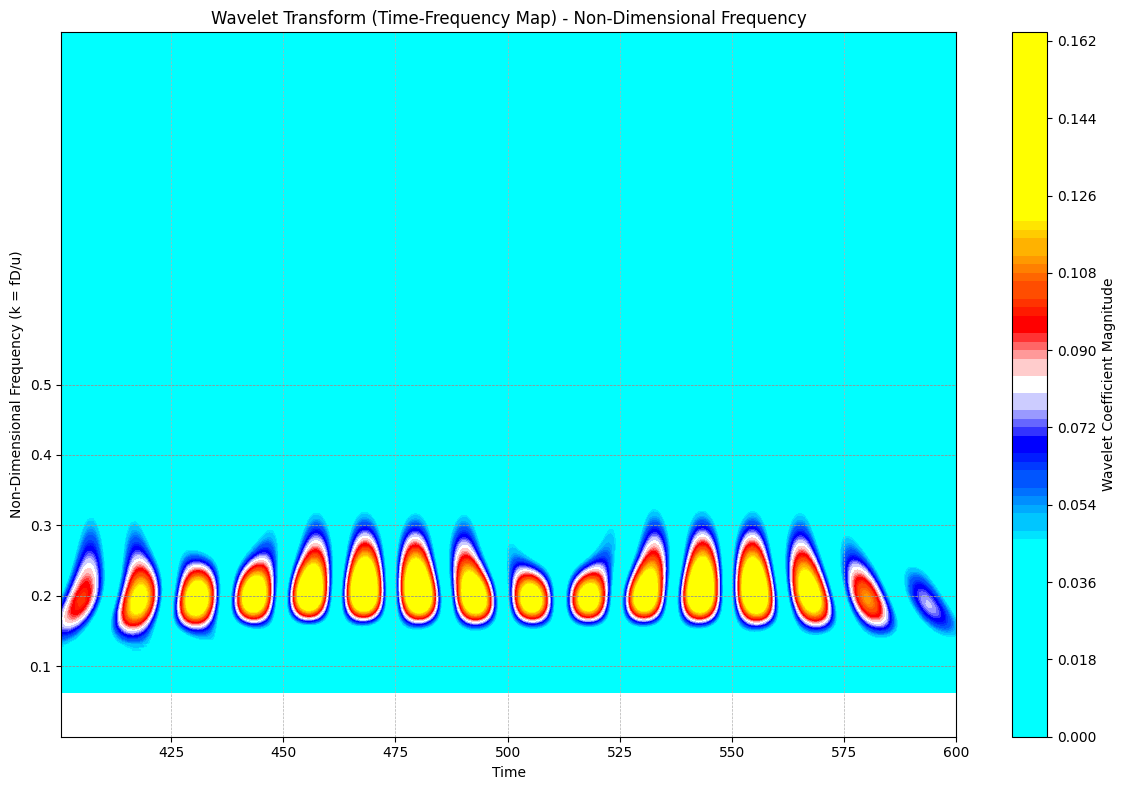

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.io import loadmat
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data
Time = data['Time'].flatten()  # Time array
nxi = int(data['nxi'])  # Number of x grid points
nyi = int(data['nyi'])  # Number of y grid points
pxnew = data['pxnew'].flatten()  # x-coordinates
pynew = data['pynew'].flatten()  # y-coordinates

# Load CCcool colormap
cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
CC = cccool_data['CC']
custom_cmap = ListedColormap(CC)

# Parameters for non-dimensional frequency
D = 1  # Characteristic length
u = 0.2  # Free-stream velocity

# Step 1: Perform wavelet transform for the spatially averaged signal
sampling_period = Time[1] - Time[0]  # Assuming uniform time steps
signal = Xnew.mean(axis=0)  # Spatially averaged signal

# Define scales for wavelet transform
scales = np.linspace(1, 128, 128)  # Adjust scale range as needed
wavelet = 'morl'  # Morlet wavelet
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period)

# Convert frequencies to non-dimensional frequency k = fD/u
non_dimensional_frequencies = frequencies * D / u

# Step 2: Plot wavelet transform (time-frequency map)
plt.figure(figsize=(12, 8))
plt.contourf(Time, non_dimensional_frequencies, np.abs(coefficients), levels=100, cmap=custom_cmap)
plt.colorbar(label='Wavelet Coefficient Magnitude')

# Explicitly set y-ticks for non-dimensional frequency k
yticks = [0.1, 0.2, 0.3, 0.4, 0.5]
plt.yticks(
    ticks=yticks,
    labels=[f"{k:.2f}" for k in yticks],
    fontsize=10
)

# Add gridlines for all y-ticks
for k in yticks:
    plt.axhline(y=k, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.title('Wavelet Transform (Time-Frequency Map) - Non-Dimensional Frequency')
plt.xlabel('Time')
plt.ylabel('Non-Dimensional Frequency (k = fD/u)')
plt.ylim(0, 1.0)  # Limit to k = 0 to 0.5
plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(mpl.ticker.ScalarFormatter())

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pywt
# from scipy.io import loadmat
# from matplotlib.colors import ListedColormap

# # Load Ground_data.mat
# file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat'
# data = loadmat(file_path)

# Xnew = data['Xnew']  # Vorticity data
# Time = data['Time'].flatten()  # Time array
# nxi = int(data['nxi'][0][0])  # Number of x grid points
# nyi = int(data['nyi'][0][0])  # Number of y grid points
# pxnew = data['pxnew'].flatten()  # x-coordinates
# pynew = data['pynew'].flatten()  # y-coordinates

# # Load CCcool colormap
# cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
# CC = cccool_data['CC']
# custom_cmap = ListedColormap(CC)

# # Parameters for non-dimensional frequency
# D = 1  # Characteristic length
# u = 0.2  # Free-stream velocity

# # Step 1: Perform wavelet transform for the spatially averaged signal
# sampling_period = Time[1] - Time[0]
# signal = Xnew.mean(axis=0)  # Spatially averaged signal

# # Define scales for wavelet transform
# scales = np.linspace(1, 128, 128)  # Adjust scale range as needed
# wavelet = 'morl'  # Morlet wavelet
# coefficients, frequencies = pywt.cwt(signal, scales, wavelet, sampling_period)

# # Convert frequencies to non-dimensional frequency k = fD/u
# non_dimensional_frequencies = frequencies * D / u

# # Step 2: Isolate coefficients for k range (0.1 to 0.3)
# k_min, k_max = 0.1, 0.3
# k_indices = np.where((non_dimensional_frequencies >= k_min) & (non_dimensional_frequencies <= k_max))[0]
# filtered_coefficients = coefficients[k_indices, :]

# # Step 3: Divide the time into subdivisions
# num_subdivisions = 8
# time_indices = np.array_split(np.arange(len(Time)), num_subdivisions)


In [15]:
# # Step 4: Aggregate coefficients and plot normalized dominant modes for each subdivision
# for i, time_idx in enumerate(time_indices):
#     # Aggregate the coefficients for the current time subdivision
#     subdivision_coefficients = filtered_coefficients[:, time_idx]
#     aggregated_coefficients = np.mean(subdivision_coefficients, axis=1)

#     # Normalize the aggregated coefficients
#     aggregated_coefficients /= np.max(np.abs(aggregated_coefficients))  # Normalize by max magnitude

#     # Map coefficients to spatial grid
#     temporal_mode = np.mean(Xnew[:, time_idx], axis=1)
#     spatial_mode = temporal_mode * np.sum(aggregated_coefficients)

#     # Normalize the spatial mode
#     spatial_mode /= np.max(np.abs(spatial_mode))  # Normalize by max spatial mode magnitude

#     # Reshape into spatial dimensions
#     mode_contour = spatial_mode.reshape((nyi, nxi))

#     # Visualize the dominant mode
#     plt.figure(figsize=(10, 6))
#     plt.contourf(pxnew.reshape((nyi, nxi)),
#                  pynew.reshape((nyi, nxi)),
#                  mode_contour,
#                  levels=100,
#                  cmap=custom_cmap,
#                  extend='both')
#     # plt.colorbar(label='Normalized Wavelet Coefficients')
#     plt.title(f'Normalized Dominant Mode for k Range {k_min:.2f} to {k_max:.2f}, Time Subdivision {i + 1}')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.tight_layout()
#     plt.show()



In [16]:
np.shape(signal)

(400,)

In [17]:
# # Step 4: Plot dominant mode at specific time instants
# specific_times = [18, 68, 112, 166, 218, 262]  # Example indices of specific time instants

# for i, time_idx in enumerate(specific_times):
#     # Extract the wavelet coefficients for the selected time
#     specific_coefficients = filtered_coefficients[:, time_idx]

#     # Normalize the coefficients for clarity
#     specific_coefficients /= np.max(np.abs(specific_coefficients))  # Normalize by max value

#     # Map coefficients to spatial grid
#     spatial_mode = Xnew[:, time_idx] * np.sum(specific_coefficients)

#     # Normalize the spatial mode
#     spatial_mode /= np.max(np.abs(spatial_mode))  # Normalize by max magnitude

#     # Reshape into spatial dimensions
#     mode_contour = spatial_mode.reshape((nyi, nxi))

#     # Visualize the dominant mode
#     plt.figure(figsize=(10, 6))
#     plt.contourf(pxnew.reshape((nyi, nxi)),
#                  pynew.reshape((nyi, nxi)),
#                  mode_contour,
#                  levels=100,
#                  cmap=custom_cmap,
#                  extend='both')
#     plt.colorbar(label='Normalized Wavelet Coefficients')
#     plt.title(f'Dominant Mode for k Range {k_min:.2f} to {k_max:.2f}, Time Instant {Time[time_idx]:.2f}')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.tight_layout()
#     plt.show()


In [18]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pywt
# from scipy.io import loadmat
# from matplotlib.colors import ListedColormap

# # Load Ground_data.mat
# file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat'
# data = loadmat(file_path)

# Xnew = data['Xnew']  # Vorticity data (n_grid_points x n_time_steps)
# Time = data['Time'].flatten()  # Time array
# nxi = int(data['nxi'][0][0])  # Number of x grid points
# nyi = int(data['nyi'][0][0])  # Number of y grid points
# pxnew = data['pxnew']  # x-coordinates (nxi x nyi)
# pynew = data['pynew']  # y-coordinates (nxi x nyi)

# # Load CCcool colormap
# cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
# CC = cccool_data['CC']
# custom_cmap = ListedColormap(CC)

# # Parameters for non-dimensional frequency
# D = 1  # Characteristic length
# u = 0.2  # Free-stream velocity

# # Define the spatial domain for averaging (x = 2.5 to 4.5, y = all)
# x_min, x_max = 2.5, 4.5
# x_grid = pxnew.reshape((nyi, nxi))
# y_grid = pynew.reshape((nyi, nxi))

# # Identify grid points within the specified domain
# subdomain_mask = (x_grid >= x_min) & (x_grid <= x_max)
# subdomain_indices = np.where(subdomain_mask.flatten())[0]  # Flattened indices for subdomain

# # Extract vorticity data for the subdomain and average over space
# subdomain_vorticity = Xnew[subdomain_indices, :]
# spatially_averaged_signal = np.mean(subdomain_vorticity, axis=0)  # Average over subdomain

# # Perform wavelet transform on the spatially averaged signal
# sampling_period = Time[1] - Time[0]  # Time step
# scales = np.linspace(1, 128, 128)  # Wavelet scales
# wavelet = 'morl'  # Morlet wavelet

# coefficients, frequencies = pywt.cwt(spatially_averaged_signal, scales, wavelet, sampling_period)

# # Convert frequencies to non-dimensional frequency k = fD/u
# non_dimensional_frequencies = frequencies * D / u

# # Filter coefficients in the k range 0.15 to 0.28
# k_min, k_max = 0.15, 0.28
# k_indices = np.where((non_dimensional_frequencies >= k_min) & (non_dimensional_frequencies <= k_max))[0]
# filtered_coefficients = coefficients[k_indices, :]

# # Aggregate coefficients across the frequency range
# aggregated_coefficients = np.sum(np.abs(filtered_coefficients), axis=0)

# # Normalize the aggregated coefficients
# aggregated_coefficients /= np.max(aggregated_coefficients)  # Normalize by max value

# # Plot wavelet spectrum for the spatially averaged signal
# plt.figure(figsize=(12, 6))
# plt.imshow(np.abs(filtered_coefficients),
#            extent=[Time[0], Time[-1], k_max, k_min],
#            aspect='auto',
#            cmap=custom_cmap,
#            origin='lower')
# plt.colorbar(label='Wavelet Coefficients (Normalized)')
# plt.title(f'Wavelet Spectrum for Spatially Averaged Vorticity (x = {x_min} to {x_max}, y = all)')
# plt.xlabel('Time')
# plt.ylabel('Non-dimensional Frequency (k)')
# plt.tight_layout()
# plt.show()

# # Plot temporal evolution of aggregated coefficients
# plt.figure(figsize=(10, 5))
# plt.plot(Time, aggregated_coefficients, label='Aggregated Coefficients', color='blue')
# plt.title('Temporal Evolution of Aggregated Wavelet Coefficients')
# plt.xlabel('Time')
# plt.ylabel('Normalized Coefficient')
# plt.grid()
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Visualize spatial modes for selected time steps
# selected_time_steps = [18, 68, 112, 166, 218, 262]  # Example time steps for spatial modes
# for t in selected_time_steps:
#     # Compute spatial mode by multiplying aggregated coefficient with the original vorticity data
#     spatial_mode = Xnew[:, t] * aggregated_coefficients[t]


#     # Normalize the spatial mode
#     spatial_mode /= np.max(np.abs(spatial_mode))

#     # Reshape into spatial dimensions
#     mode_contour = spatial_mode.reshape((nyi, nxi))

#     # Plot spatial mode
#     plt.figure(figsize=(10, 6))
#     plt.contourf(x_grid, y_grid, mode_contour, levels=100, cmap=custom_cmap, extend='both')
#     plt.colorbar(label='Normalized Mode Amplitude')
#     plt.title(f'Spatial Mode at Time Step {t}')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.tight_layout()
#     plt.show()



Apply a Continuous Wavelet Transform (CWT) on Key Modes
If interested in specific flow structures (e.g., vortices or coherent patterns), project the vorticity field onto key spatial modes (e.g., using Proper Orthogonal Decomposition or Fourier transforms). Perform the wavelet transform only on these modes.

How It Works:
Extract Modes:
Use techniques like Proper Orthogonal Decomposition (POD) to extract dominant spatial modes.
Wavelet Transform:
Perform wavelet transforms on the time coefficients of these modes.
Advantages:
Focuses on the most energetic or dynamically significant features.
Reduces computational load significantly.

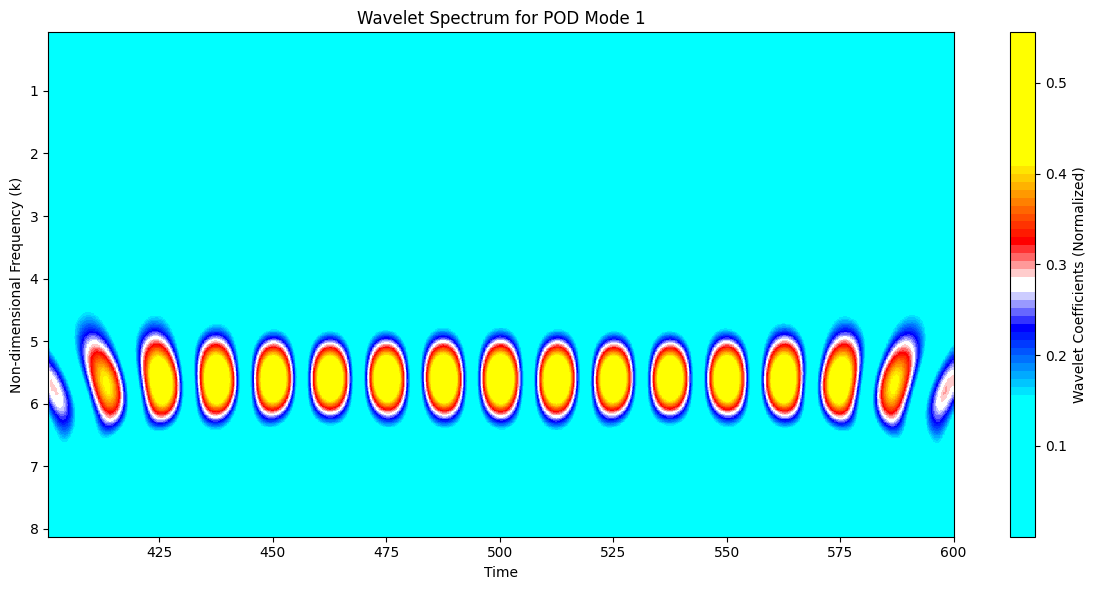

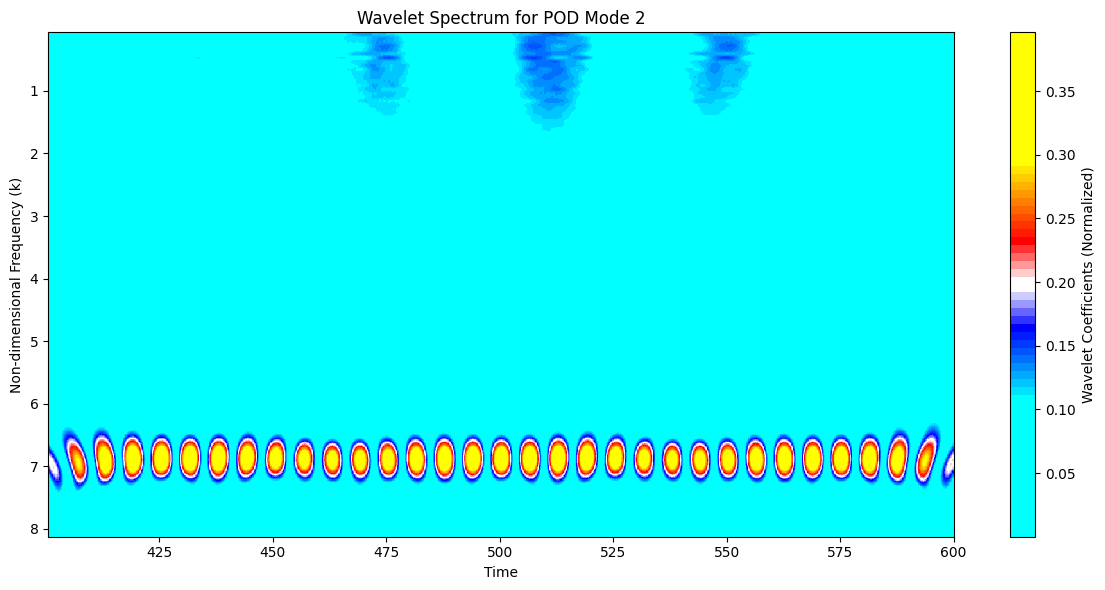

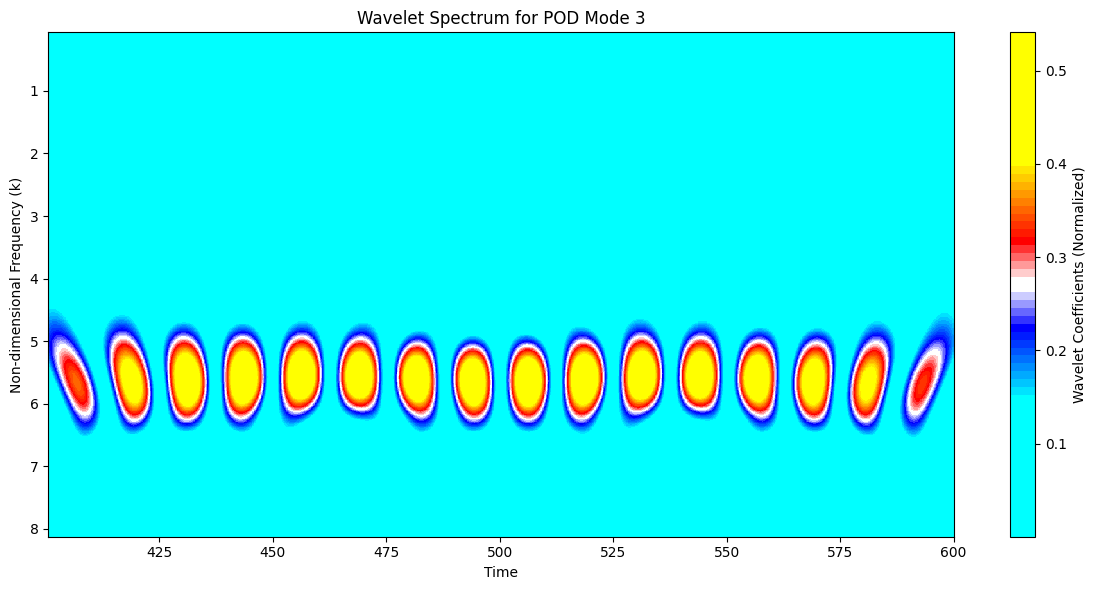

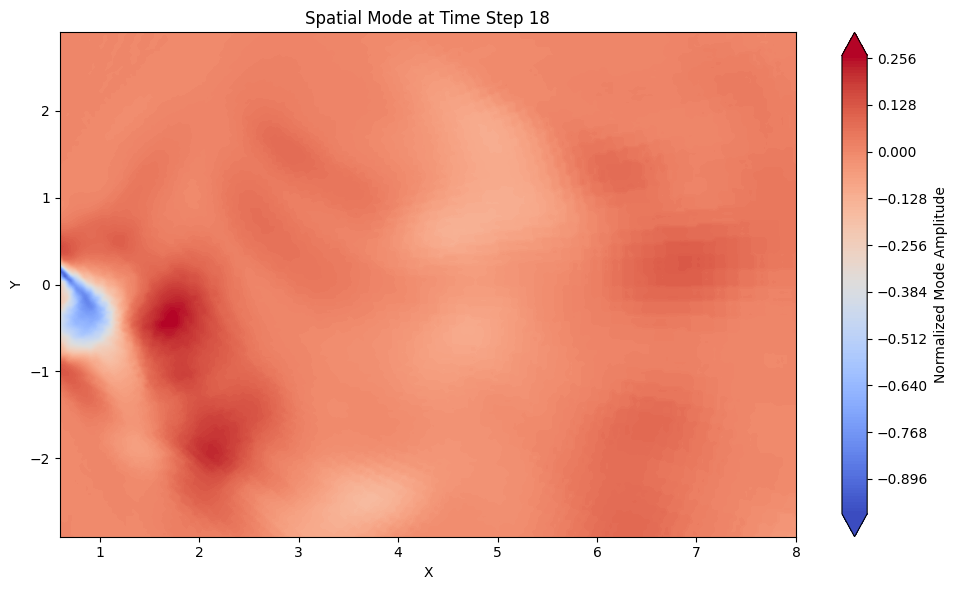

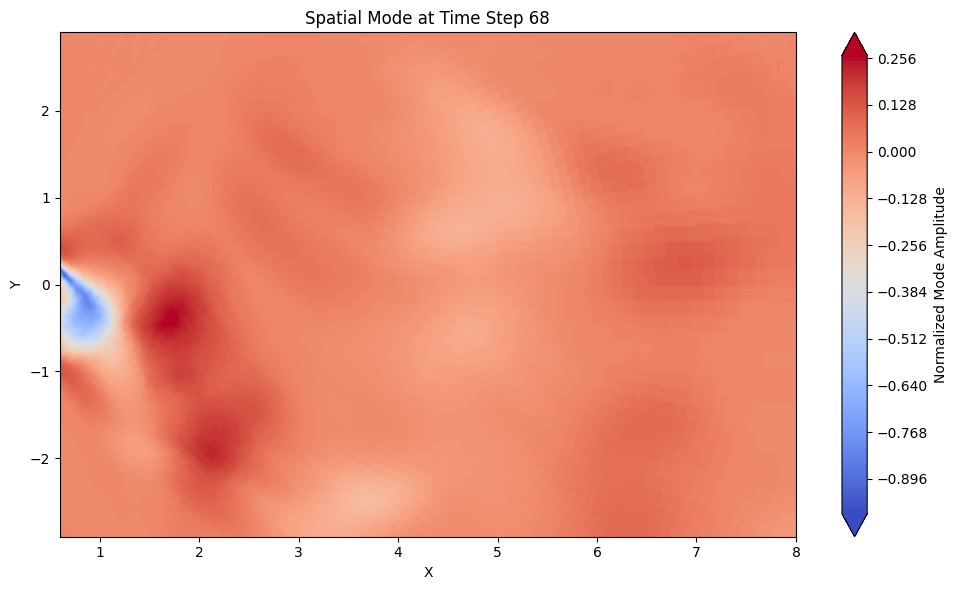

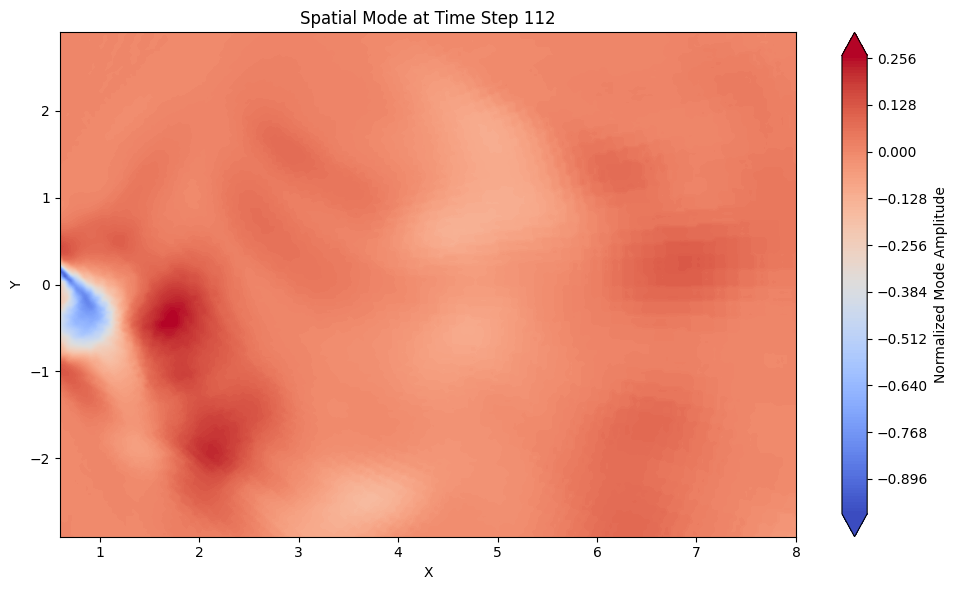

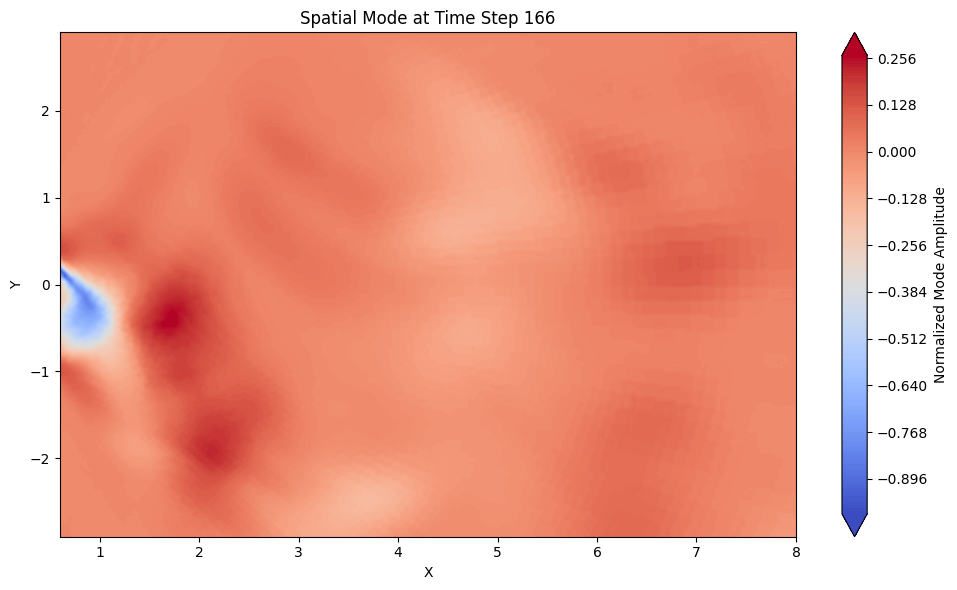

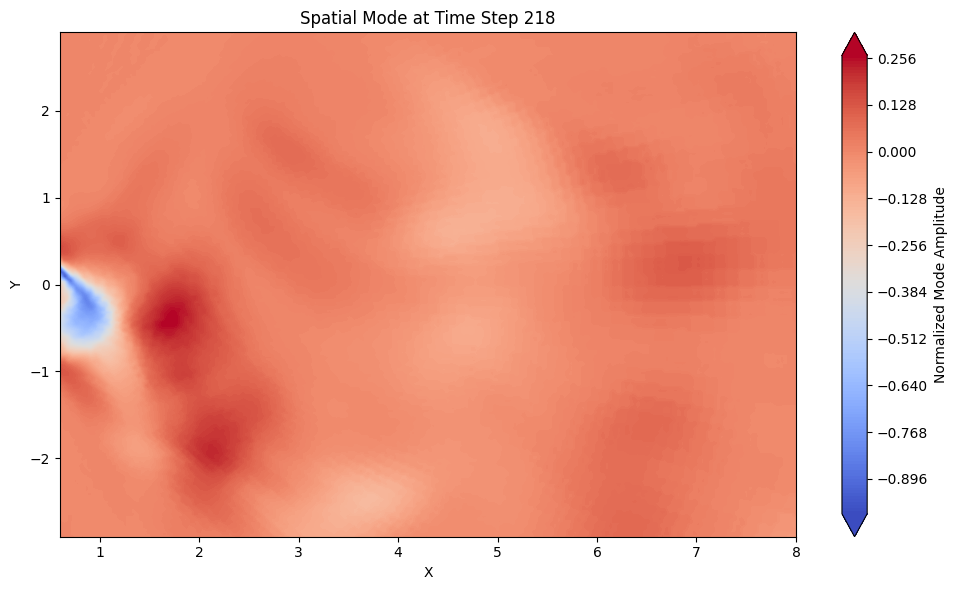

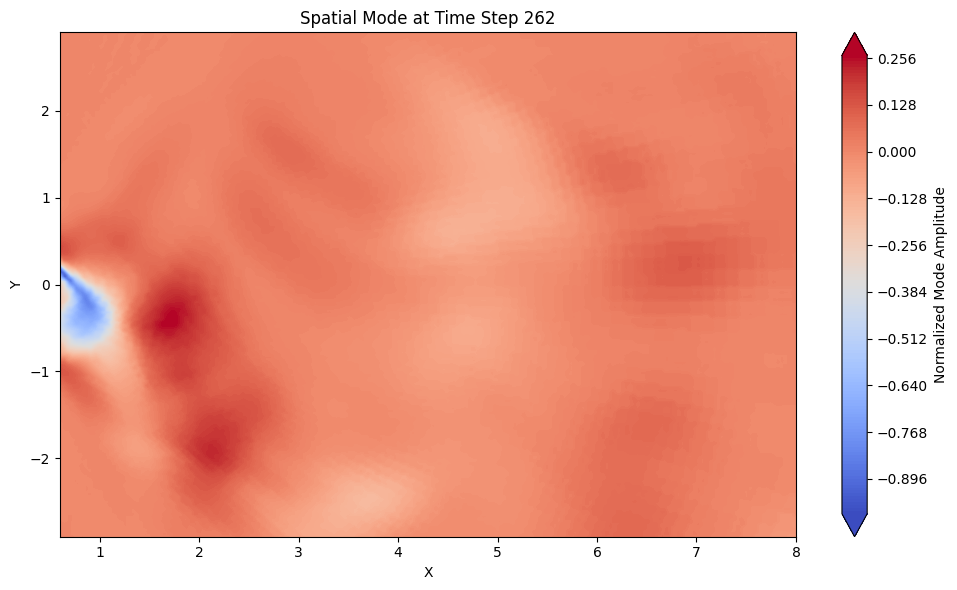

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.linalg import svd
from scipy.io import loadmat
from matplotlib.colors import ListedColormap

# Load Ground_data.mat
file_path = '/content/drive/MyDrive/Re500_RV5_D0p9/Ground_data.mat'
data = loadmat(file_path)

Xnew = data['Xnew']  # Vorticity data (n_grid_points x n_time_steps)
Time = data['Time'].flatten()  # Time array
nxi = int(data['nxi'][0][0])  # Number of x grid points
nyi = int(data['nyi'][0][0])  # Number of y grid points
pxnew = data['pxnew']  # x-coordinates (nxi x nyi)
pynew = data['pynew']  # y-coordinates (nxi x nyi)

# Load CCcool colormap
cccool_data = loadmat('/content/drive/MyDrive/Re500_RV5_D0p9/CCcool.mat')
CC = cccool_data['CC']
custom_cmap = ListedColormap(CC)

# Perform Proper Orthogonal Decomposition (POD)
def compute_pod(data):
    """
    Perform POD on the vorticity data.
    Args:
        data: 2D array of shape (n_grid_points, n_time_steps)
    Returns:
        modes: POD spatial modes
        singular_values: Singular values (energy contribution of each mode)
        time_coefficients: Time coefficients corresponding to each mode
    """
    # Subtract mean to compute fluctuations
    mean_field = np.mean(data, axis=1, keepdims=True)
    fluctuations = data - mean_field

    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = svd(fluctuations, full_matrices=False)
    modes = U  # Spatial modes
    singular_values = S  # Singular values
    time_coefficients = Vt.T  # Time coefficients
    return modes, singular_values, time_coefficients, mean_field

# Compute POD
modes, singular_values, time_coefficients, mean_field = compute_pod(Xnew)

# Retain multiple dominant modes
num_dominant_modes = 3  # Number of dominant modes to consider
dominant_modes = modes[:, :num_dominant_modes]
time_coefficients_for_modes = time_coefficients[:, :num_dominant_modes]

# Perform Continuous Wavelet Transform (CWT) on the time coefficients of dominant modes
scales = np.linspace(1, 128, 128)  # Wavelet scales
wavelet = 'morl'  # Morlet wavelet
D = 1  # Characteristic length
u = 0.2  # Free-stream velocity

all_coefficients = []
frequencies = None
for i in range(num_dominant_modes):
    coeffs, freqs = pywt.cwt(time_coefficients_for_modes[:, i], scales, wavelet, Time[1] - Time[0])
    all_coefficients.append(coeffs)
    if frequencies is None:
        frequencies = freqs  # Save frequencies from the first computation

# Combine wavelet coefficients from all dominant modes
combined_coefficients = np.sum(np.abs(all_coefficients), axis=0)

# Convert frequencies to non-dimensional frequency k = fD/u
non_dimensional_frequencies = frequencies * D / u

# Visualize Wavelet Transform for Each Mode
for i in range(num_dominant_modes):
    plt.figure(figsize=(12, 6))
    plt.imshow(np.abs(all_coefficients[i]),
               extent=[Time[0], Time[-1], max(non_dimensional_frequencies), min(non_dimensional_frequencies)],
               aspect='auto', cmap=custom_cmap, origin='lower')
    plt.colorbar(label='Wavelet Coefficients (Normalized)')
    plt.title(f'Wavelet Spectrum for POD Mode {i + 1}')
    plt.xlabel('Time')
    plt.ylabel('Non-dimensional Frequency (k)')
    plt.tight_layout()
    plt.show()

# Aggregate coefficients across the frequency range
k_min, k_max = 0.15, 0.28
k_indices = np.where((non_dimensional_frequencies >= k_min) & (non_dimensional_frequencies <= k_max))[0]
filtered_coefficients = combined_coefficients[k_indices, :]
aggregated_coefficients = np.sum(np.abs(filtered_coefficients), axis=0)

# Reconstruct and Visualize Spatial Modes at Selected Time Steps
selected_time_steps = [18, 68, 112, 166, 218, 262]
for t in selected_time_steps:
    # Combine dominant modes with time-dependent wavelet coefficients
    spatial_mode = np.sum(dominant_modes * aggregated_coefficients[t], axis=1)

    # Normalize the spatial mode
    spatial_mode /= np.max(np.abs(spatial_mode))

    # Reshape into spatial dimensions
    mode_contour = spatial_mode.reshape((nyi, nxi))

    # Plot spatial mode
    plt.figure(figsize=(10, 6))
    plt.contourf(pxnew.reshape((nyi, nxi)), pynew.reshape((nyi, nxi)),
                 mode_contour, levels=200, cmap='coolwarm', extend='both')
    plt.colorbar(label='Normalized Mode Amplitude')
    plt.title(f'Spatial Mode at Time Step {t}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.tight_layout()
    plt.show()
